[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d2kYPsvC9MLgBhpsRJfMS8SvpMlTmF4Q?usp=sharing)

# Imbalanced classification: credit card fraud detection

https://keras.io/examples/structured_data/imbalanced_classification/

## Introduction

This example looks at the
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/)
dataset to demonstrate how
to train a classification model on data with highly imbalanced classes.

## First, vectorize the CSV data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/data

creditcard.csv


In [5]:
import csv
import numpy as np

# Get the real data from --> https://www.kaggle.com/mlg-ulb/creditcardfraud/
fname = "/content/drive/MyDrive/data/creditcard.csv"

all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


## Prepare a validation set

In [6]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples].squeeze()
train_targets = targets[:-num_val_samples]
test_features = features[-num_val_samples:].squeeze()
test_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_targets))
print("Number of validation samples:", len(test_features))

Number of training samples: 227846
Number of validation samples: 56961


## [Recommended] Normalize the data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

## Build a binary classification model

In [8]:
import keras

model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 248       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Exercise: detects 90% of frauds in test dataset (TP >= 68)

**Tips**: check the following documentation (class weight parameter): https://keras.io/api/models/model_training_apis/#fit-method

In [9]:
print(train_targets.shape)
print(train_features.shape)

(227846, 1)
(227846, 30)


In [10]:
metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-3),
    loss="binary_crossentropy",
    metrics=metrics
)

# callbacks
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # mode='max',
    patience=15,
    verbose=1)

# class weights
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
weight_for_0 = train_features.shape[0] / (2 * counts[0])
weight_for_1 = train_features.shape[0] / (2 * counts[1])
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

# train the model
model.fit(
    train_features,
    train_targets,
    batch_size=1024,
    epochs=200,
    callbacks=[es_callback],
    verbose=2,
    validation_split=0.35,
    class_weight=class_weight,
)

Number of positive samples in training data: 417 (0.18% of total)
{0: 0.500916769629203, 1: 273.1966426858513}
Epoch 1/200
145/145 - 5s - loss: 0.5027 - tp: 200.0000 - tn: 126254.0000 - fn: 85.0000 - fp: 21560.0000 - precision: 0.0092 - recall: 0.7018 - val_loss: 0.4863 - val_tp: 115.0000 - val_tn: 75826.0000 - val_fn: 17.0000 - val_fp: 3789.0000 - val_precision: 0.0295 - val_recall: 0.8712 - 5s/epoch - 37ms/step
Epoch 2/200
145/145 - 1s - loss: 0.3323 - tp: 217.0000 - tn: 144371.0000 - fn: 68.0000 - fp: 3443.0000 - precision: 0.0593 - recall: 0.7614 - val_loss: 0.3479 - val_tp: 120.0000 - val_tn: 76443.0000 - val_fn: 12.0000 - val_fp: 3172.0000 - val_precision: 0.0365 - val_recall: 0.9091 - 789ms/epoch - 5ms/step
Epoch 3/200
145/145 - 1s - loss: 0.2768 - tp: 234.0000 - tn: 144873.0000 - fn: 51.0000 - fp: 2941.0000 - precision: 0.0737 - recall: 0.8211 - val_loss: 0.3325 - val_tp: 121.0000 - val_tn: 74579.0000 - val_fn: 11.0000 - val_fp: 5036.0000 - val_precision: 0.0235 - val_recall: 0

In [12]:
results = model.evaluate(test_features, test_targets, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test TP: {}'.format(results[1]))

Test Loss: 0.27626708149909973
Test TP: 71.0


1781/1781 [==============================] - 3s 2ms/step
Legitimate Transactions Detected (True Negatives):  49364
Legitimate Transactions Incorrectly Detected (False Positives):  7522
Fraudulent Transactions Missed (False Negatives):  4
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  75
Legitimate Transactions Detected (True Negatives):  32657
Legitimate Transactions Incorrectly Detected (False Positives):  24229
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  75


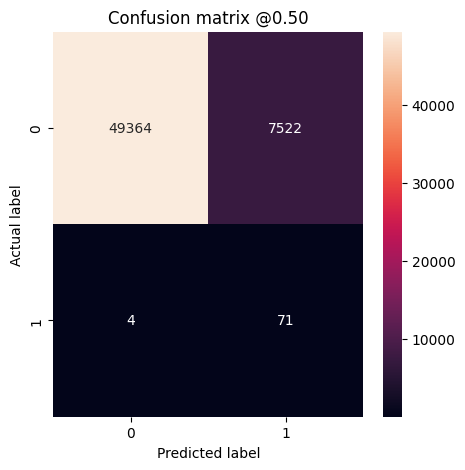

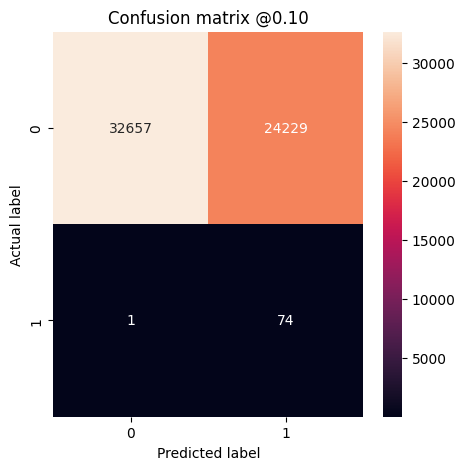

In [17]:
# improve results changing threshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_predictions_baseline = model.predict(test_features)

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(test_targets, test_predictions_baseline, threshold=0.5)
plot_cm(test_targets, test_predictions_baseline, threshold=0.1)